
# Multi-class (One-vs-All) Logistic Regression on MNIST — **Clear Weight Maps** (CUDA/MPS Ready)

This version optimizes for **visual clarity** of the learned weights:
- Adds light **L2 weight decay** for smoother, less noisy templates
- Applies a small **Gaussian blur** (no extra deps) before plotting
- Upsamples with **bicubic** and uses **TwoSlopeNorm** centered at 0
- Overlays a **zero contour** so you can see the neutral boundary

It still follows the structure you wanted: `sigmoid` → cost with reg → one-vs-all → training/testing → visualization.


In [20]:

import os, random, numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# Reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device selection
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

DEVICE = get_device()
print("Using device:", DEVICE)
if DEVICE.type == "cuda":
    print("CUDA:", torch.cuda.get_device_name(0))
elif DEVICE.type == "mps":
    print("Apple Metal (MPS) backend active")


Using device: cuda
CUDA: NVIDIA GeForce RTX 3090


Sigmoid Activation Function

In [21]:

def sigmoid(t):
    if isinstance(t, torch.Tensor):
        return torch.sigmoid(t)
    return torch.sigmoid(torch.as_tensor(t, dtype=torch.float32)).numpy()


Try plotting the sigmoid function by synethsizing your own data.

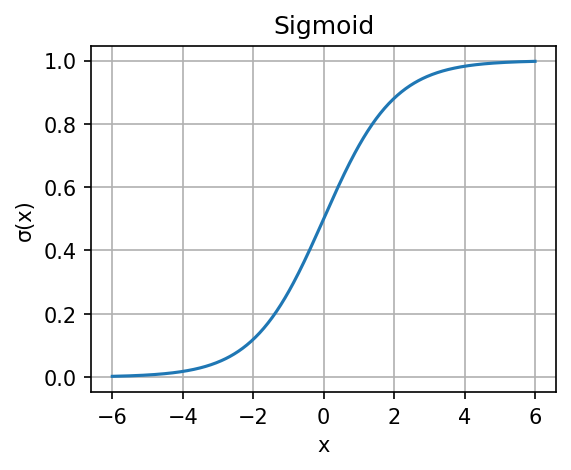

In [22]:

x = torch.linspace(-6, 6, 400)
y = sigmoid(x)
plt.figure(figsize=(4,3), dpi=150)
plt.plot(x.cpu().numpy(), y.cpu().numpy())
plt.title("Sigmoid"); plt.xlabel("x"); plt.ylabel("σ(x)"); plt.grid(True); plt.show()


In [23]:

def displayData(X, rows=5, cols=5, title="25 Random Training Digits (labels in titles)"):
    if isinstance(X, np.ndarray):
        X = torch.from_numpy(X)
    X = X.float()
    N = X.shape[0]
    assert rows * cols <= N
    idxs = torch.randperm(N)[:rows*cols]

    fig, axes = plt.subplots(rows, cols, figsize=(6,6), dpi=150)
    fig.suptitle(title)
    for ax, idx in zip(axes.ravel(), idxs):
        ax.imshow(X[idx].view(28,28), cmap="gray", interpolation="nearest")
        ax.axis("off")
    for ax in axes.ravel()[rows*cols:]:
        ax.axis("off")
    plt.tight_layout(); plt.show()


# Cost Function with Regularization

In [24]:

def costFunction(theta, X, y, lambda_reg, return_grad=False):
    X = X.to(DEVICE)
    y = y.to(DEVICE).float()
    w = theta[:-1]
    b = theta[-1:]
    logits = X @ w + b
    loss_vec = F.binary_cross_entropy_with_logits(logits, y, reduction='none')
    loss = loss_vec.mean() + (lambda_reg/(2.0*X.size(0))) * (w @ w)
    if return_grad:
        loss.backward()
        grad = theta.grad.clone()
        theta.grad.zero_()
        return loss.detach(), grad.detach()
    return loss.detach()



Multiclass regression as 1 vs All: train K binary classifiers (class vs rest) and select the class with the highest probability.


In [25]:

class OVRLogReg(nn.Module):
    def __init__(self, in_dim=28*28, num_classes=10):
        super().__init__()
        self.linear = nn.Linear(in_dim, num_classes, bias=True)
    def forward(self, x):
        if x.dim() == 4:
            x = x.view(x.size(0), -1)
        return self.linear(x)

def oneVsAll(X, y, num_labels, lambda_reg=1e-3, epochs=5, lr=1e-2, batch_size=128):
    N, D = X.shape
    loader = DataLoader(TensorDataset(X, y), batch_size=batch_size, shuffle=True)
    model = OVRLogReg(in_dim=D, num_classes=num_labels).to(DEVICE)
    # weight_decay implements L2 regularization → smoother templates
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lambda_reg)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(1, epochs+1):
        model.train()
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            ybh = F.one_hot(yb, num_classes=num_labels).float().to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, ybh)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        if DEVICE.type == "mps":
            torch.mps.synchronize()
        with torch.no_grad():
            preds = predictOneVsAll(model, X)
            acc = (preds == y.cpu().numpy()).mean()
        print(f"Epoch {epoch:02d}/{epochs} | train_acc={acc*100:.2f}%")
    return model

@torch.no_grad()
def predictOneVsAll(model, X):
    logits = model(X.to(DEVICE))
    probs = torch.sigmoid(logits)
    return probs.argmax(dim=1).cpu().numpy()


# Training, Test and Validation Set

Train: torch.Size([60000, 784]) torch.Size([60000])  Test: torch.Size([10000, 784]) torch.Size([10000])


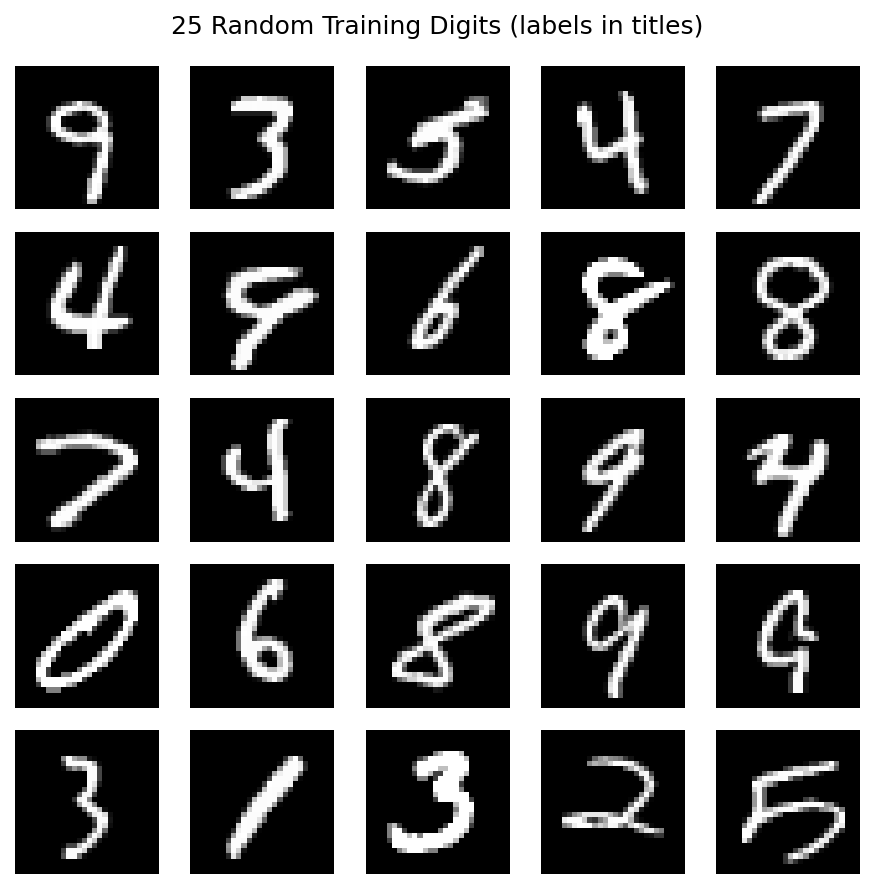

In [26]:

transform = transforms.Compose([transforms.ToTensor()])

root = os.path.join('.', 'data')
train_ds = datasets.MNIST(root=root, train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root=root, train=False, download=True, transform=transform)

X_train = torch.stack([img for img, _ in train_ds]).view(len(train_ds), -1)
y_train = torch.tensor([lbl for _, lbl in train_ds], dtype=torch.long)
X_test  = torch.stack([img for img, _ in test_ds]).view(len(test_ds), -1)
y_test  = torch.tensor([lbl for _, lbl in test_ds], dtype=torch.long)

print("Train:", X_train.shape, y_train.shape, " Test:", X_test.shape, y_test.shape)
displayData(X_train, rows=5, cols=5)


## Train One-vs-All Logistic Regression (with light L2 regularization)

In [27]:

num_labels = 10
lambda_reg = 1e-3   # try 5e-4..2e-3 for smoothness vs accuracy
epochs = 6
lr = 1e-2
batch_size = 128

model = oneVsAll(X_train, y_train, num_labels, lambda_reg=lambda_reg, epochs=epochs, lr=lr, batch_size=batch_size)
test_preds = predictOneVsAll(model, X_test)
test_acc = (test_preds == y_test.numpy()).mean()
print(f"Test accuracy: {test_acc*100:.2f}%")


Epoch 01/6 | train_acc=88.72%
Epoch 02/6 | train_acc=88.45%
Epoch 03/6 | train_acc=88.16%
Epoch 04/6 | train_acc=88.19%
Epoch 05/6 | train_acc=87.27%
Epoch 06/6 | train_acc=87.52%
Test accuracy: 88.39%


## Visualize learned weights — **high-clarity contours**

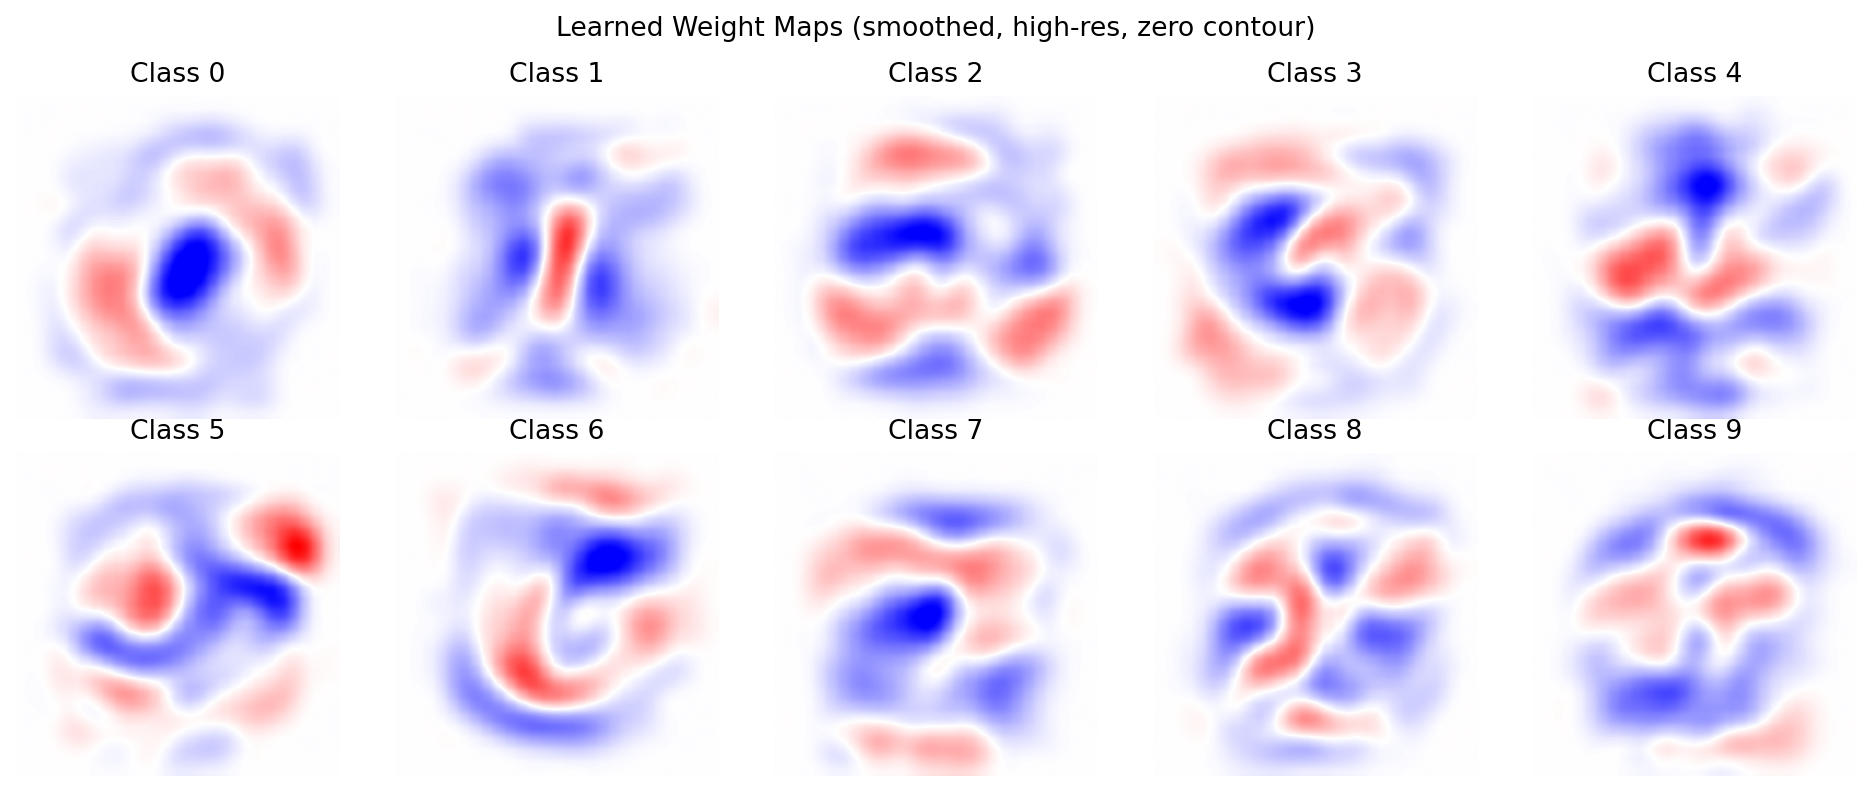

In [29]:

# Gaussian blur via conv2d (no SciPy needed)
def gaussian_blur_np(img, sigma=1.0, k=9):
    # Build Gaussian kernel
    ax = torch.arange(k) - k//2
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = (kernel / kernel.sum()).unsqueeze(0).unsqueeze(0)  # (1,1,k,k)

    t = torch.from_numpy(img).float().unsqueeze(0).unsqueeze(0)  # (1,1,H,W)
    pad = k//2
    out = F.conv2d(t, kernel, padding=pad).squeeze().numpy()
    return out

with torch.no_grad():
    W = model.linear.weight.detach().cpu().numpy()  # (K, 784)

# Consistent symmetric scaling across classes for fair comparison
vmax = float(np.percentile(np.abs(W), 99))
vmax = max(vmax, 1e-6)
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

rows, cols = 2, 5
fig, axes = plt.subplots(rows, cols, figsize=(12, 5), dpi=160)
fig.suptitle("Learned Weight Maps (smoothed, high-res, zero contour)")

for k, ax in enumerate(axes.ravel()):
    wk = W[k].reshape(28, 28)
    # light blur → clearer shapes, less pixel noise
    wk_blur = gaussian_blur_np(wk, sigma=0.9, k=7)

    # upsample to high resolution for smooth edges
    wk_t = torch.from_numpy(wk_blur).float().unsqueeze(0).unsqueeze(0)
    wk_up = F.interpolate(wk_t, size=(320, 320), mode="bicubic", align_corners=False).squeeze().numpy()

    im = ax.imshow(wk_up, cmap="bwr", norm=norm, interpolation="lanczos")
    #ax.contour(wk_up, levels=[0], linewidths=0.8, colors="k")
    ax.set_title(f"Class {k}")
    ax.axis("off")

#cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.8, pad=0.02)
#cbar.set_label("Weight value (TwoSlopeNorm centered at 0)")
plt.tight_layout()
plt.show()



### Why this looks clearer
- **L2 regularization** dampens spiky weights (less noise).
- **Gaussian blur** reveals the *shape* the linear model prefers per digit.
- **TwoSlopeNorm** keeps zero in the middle so positive/negative are balanced.
- **High-DPI, upsampling, and Lanczos** interpolation remove blocky artifacts.

Try adjusting:
- `lambda_reg` (↑ for smoother, ↓ for sharper)
- `sigma` in `gaussian_blur_np` (0.7–1.2 is a sweet spot)
- `levels` and `size` if you switch to `contourf` for stylistic contours.
